In [1]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.16.1'

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import os
from tensorflow.keras import layers
import time
import zipfile

from IPython import display

In [3]:
train_zip_path = r'C:\Users\paupl\Downloads\monet_jpg.zip'
test_zip_path = r'C:\Users\paupl\Downloads\photo_jpg.zip'

train_extract_dir = r'C:\Users\paupl\Downloads\monet_jpg'
test_extract_dir = r'C:\Users\paupl\Downloads\photo_jpg'

with zipfile.ZipFile(train_zip_path) as zip_ref:
    zip_ref.extractall(train_extract_dir)

with zipfile.ZipFile(test_zip_path) as zip_ref:
    zip_ref.extractall(test_extract_dir)

In [4]:
def load_images_from_folder(folder, img_size=(256, 256)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path)  # Open the image file
            img = img.resize(img_size)  # Resize the image
            img = tf.keras.preprocessing.image.img_to_array(img)  # Convert to array
            images.append(img)
        except (IOError, OSError, ValueError) as e:
            print(f"Error loading image {img_path}: {e}")
    return tf.convert_to_tensor(images)

train_images = load_images_from_folder(train_extract_dir)

train_images = (train_images - 127.5) / 127.5

In [5]:
BUFFER_SIZE = 400
BATCH_SIZE = 20

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
len(list(train_dataset.as_numpy_iterator()))
#es igual a la cantidad de elementos (300) dividido el tamaño que definí del batch (20), entonces 300/20=15

15

In [8]:
image_shape = train_images.shape[1:]
print(image_shape)

(256, 256, 3)


In [9]:
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 4

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256*256*3, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((256, 256, 3)))
    assert model.output_shape == (None, 256, 256, 3)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 512, 512, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 2256, 1024, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 1024, 1024, 3)

    return model

c:\Users\paupl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0063630063..0.008072969].


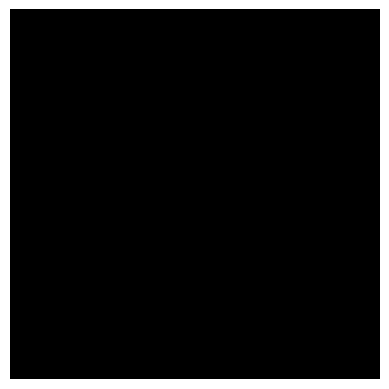

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0])
plt.axis('off')
plt.show()

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[1024, 1024, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[4.195483e-05]], shape=(1, 1), dtype=float32)


c:\Users\paupl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [36]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    print("Shape of image batch:", images.shape)


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      resized_generated_images = tf.image.resize(generated_images, [256, 256], method='nearest')

      print("Shape of generated images:", generated_images.shape)


      real_output = discriminator(images, training=True)
      fake_output = discriminator(resized_generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [37]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [38]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i] * 127.5 + 127.5) / 255.0) 
      plt.axis('off')

  plt.show()

In [39]:
train(train_dataset, EPOCHS)

Shape of image batch: (20, 256, 256, 3)
Shape of generated images: (20, 1024, 1024, 3)


ValueError: in user code:

    File "C:\Users\paupl\AppData\Local\Temp\ipykernel_21784\1801776772.py", line 14, in train_step  *
        real_output = discriminator(images, training=True)
    File "c:\Users\paupl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\paupl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling Sequential.call().
    
    [1mInput 0 of layer "dense_1" is incompatible with the layer: expected axis -1 of input shape to have value 8388608, but received input with shape (20, 524288)[0m
    
    Arguments received by Sequential.call():
      • inputs=tf.Tensor(shape=(20, 256, 256, 3), dtype=float32)
      • training=True
      • mask=None
